In [2]:
# imports 

import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
os.chdir('../..')
print(os.getcwd())
import numpy as np
import torch
from sklearn.cross_decomposition import CCA
from numpy import pi
from matplotlib import pyplot as plt
from firefly_utils.data_handler import data_handler
from firefly_utils.spike_times_class import spike_counts
from firefly_utils.behav_class import *
from firefly_utils.lfp_class import lfp_class
from copy import deepcopy
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.io import loadmat
import pickle
import pandas as pd
from numpy.lib.npyio import save
from cmaes import CMA
import copy
import matplotlib.pyplot as plt
import warnings
import heapq
from torch.distributions.multivariate_normal import MultivariateNormal
import time
from stable_baselines3 import TD3
from InverseFuncs import *
from monkey_functions import *
from firefly_task import ffacc_real
from env_config import Config
from notification import notify
from pathlib import Path
from sklearn import linear_model
import configparser
from plot_ult import *
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import numpy as np
import pickle
from pathlib import Path
import os
import sys
import random
import configparser
from plot_ult import *
import scipy.interpolate as interpolate
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


/


In [8]:
# load and process data

# change back to the workspaces
os.chdir('workspaces/ffsb/')


config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir=config['Datafolder']['data']
resdir = Path(resdir)


dat = loadmat(resdir/'neuraltest/m53s31.mat') # this is a example session with good recording, more neurons
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example

behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key, behav_stat_key, pre_trial_dur=pre_trial_dur, extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur,extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)
# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ=dict_to_vec(exp_data.behav.events.t_targ)
t_start=t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel','ang_vel','x_monk','y_monk', 'eye_hori', 'eye_vert','x_fly_screen','z_fly_screen','x_eye_screen','z_eye_screen',"x_fly_rel","y_fly_rel","ang_vel"
y,X,trial_idx = exp_data.concatenate_inputs(*var_names,t_start=t_start,t_stop=t_stop, time_stamps=ts)


unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter


In [9]:
trials=np.unique(trial_idx)
len(trials)

700

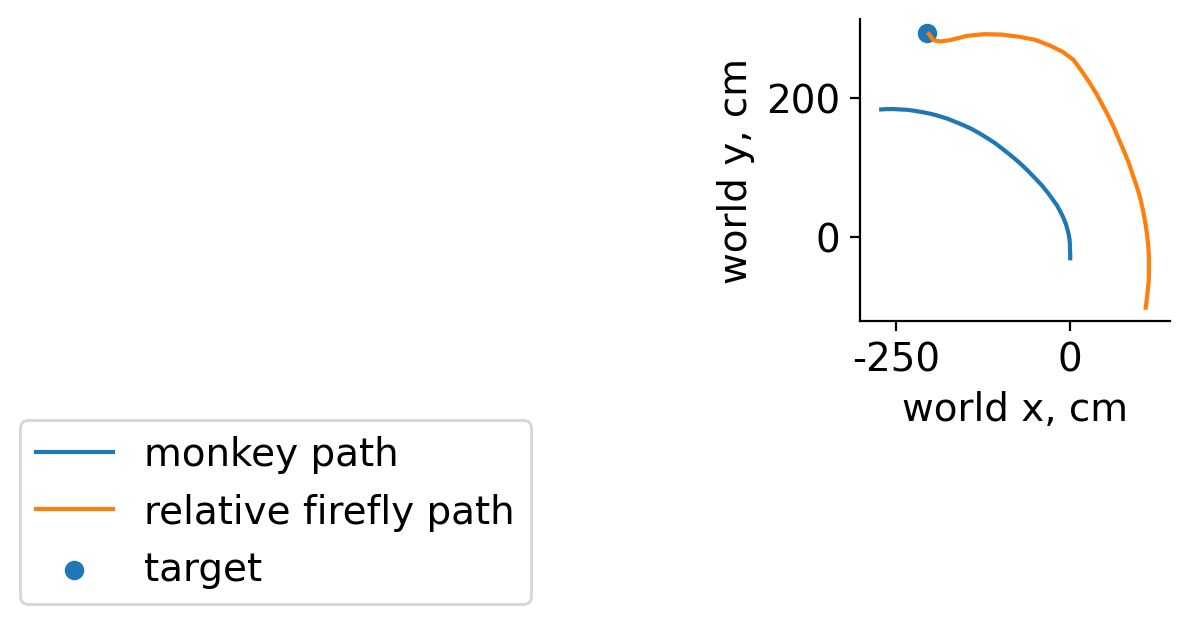

In [13]:
# verify, relative position overhead

# itrial=0
itrial+=1

with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    plt.plot(X['x_monk'][trial_idx==trials[itrial]], X['y_monk'][trial_idx==trials[itrial]],label='monkey path')
    plt.plot(X['x_fly_rel'][trial_idx==trials[itrial]], X['y_fly_rel'][trial_idx==trials[itrial]]-32.5,label='relative firefly path')
    plt.scatter(exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]],label='target')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('world x, cm')
    ax.set_ylabel('world y, cm')
    quickleg(ax)
    # quicksave('example overhead mk position relative itrial{}'.format(itrial))


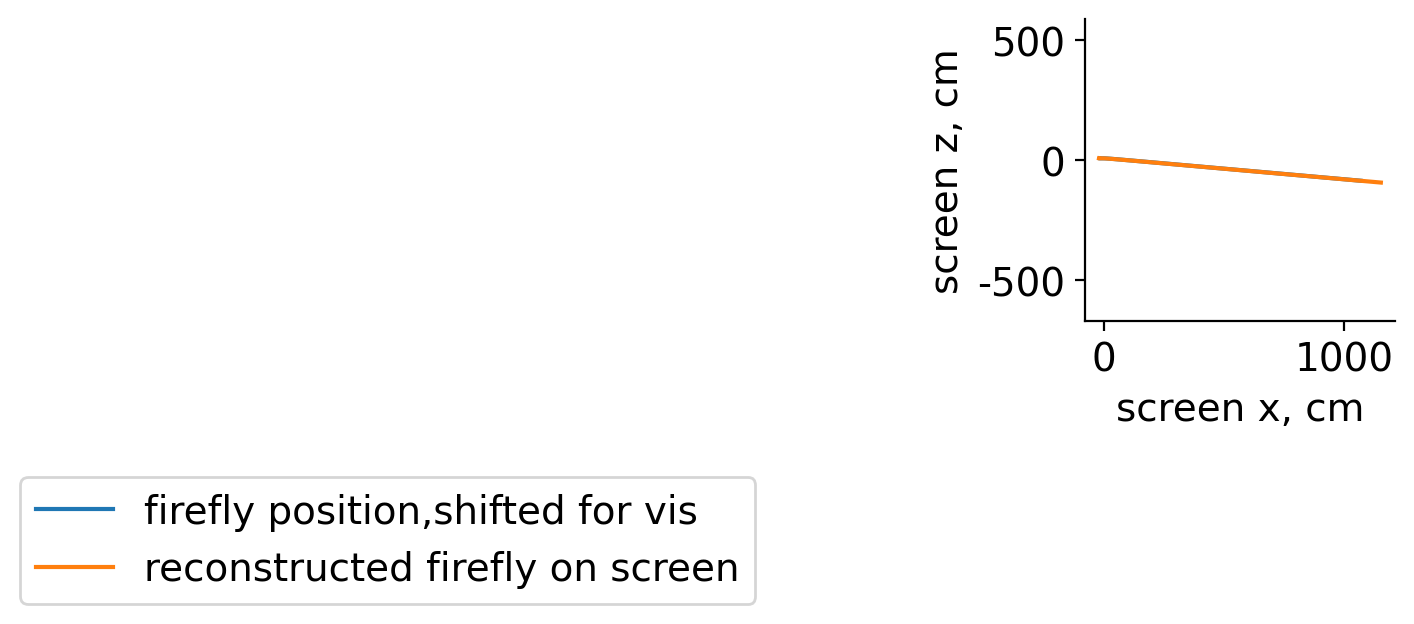

In [14]:
# verify, world 2 screen, firefly position
with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    xx,yy=world2screen(X['x_fly_rel'][trial_idx==trials[itrial]], X['y_fly_rel'][trial_idx==trials[itrial]])
    plt.plot(xx+3, yy, label='firefly position,shifted for vis')
    plt.plot(X['x_fly_screen'][trial_idx==trials[itrial]], X['z_fly_screen'][trial_idx==trials[itrial]], label='reconstructed firefly on screen')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('screen x, cm')
    ax.set_ylabel('screen z, cm')
    quickleg(ax)
    # quicksave('example screen mk position relative itrial{}'.format(itrial))


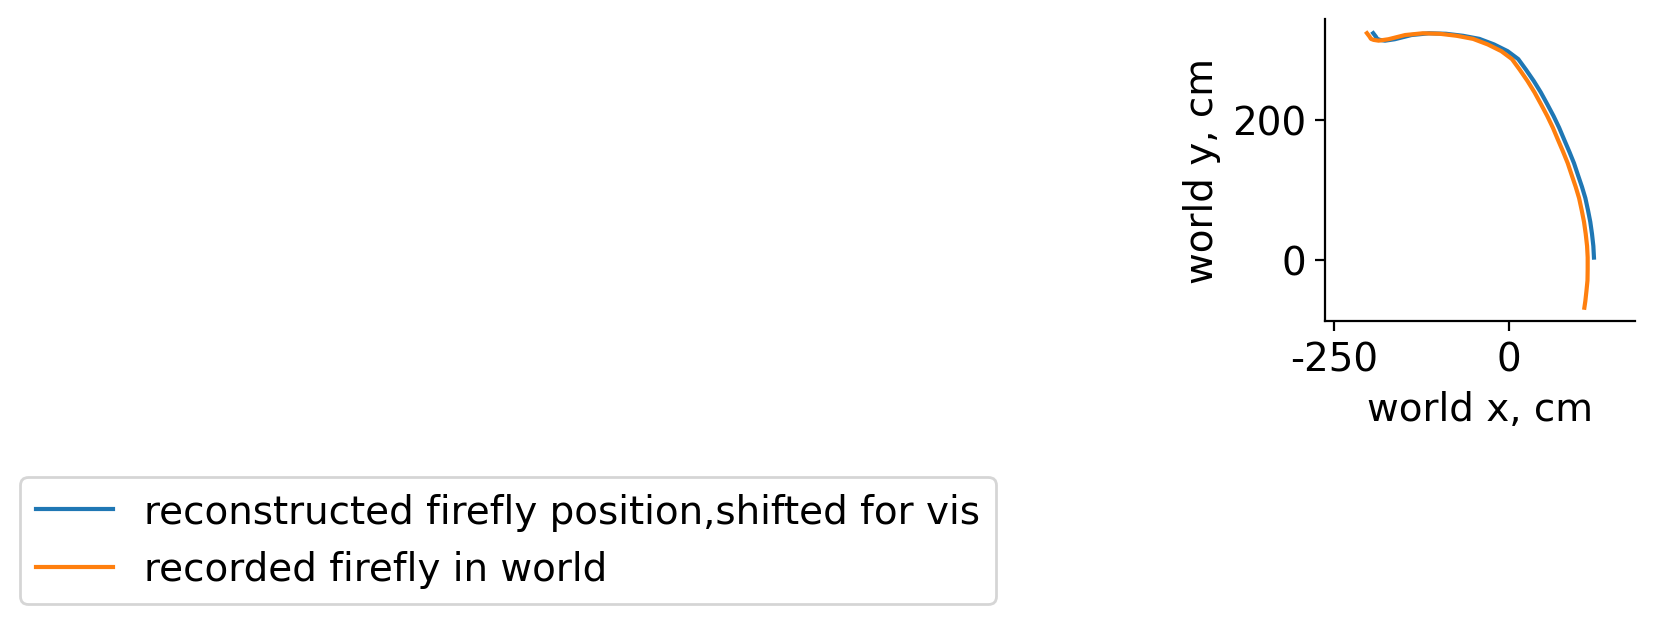

In [15]:
# verity, screen 2 world, firefly position
with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    xx,yy=screen2world(X['x_fly_screen'][trial_idx==trials[itrial]], X['z_fly_screen'][trial_idx==trials[itrial]])
    plt.plot(xx+9, yy, label='reconstructed firefly position,shifted for vis')
    plt.plot(X['x_fly_rel'][trial_idx==trials[itrial]], X['y_fly_rel'][trial_idx==trials[itrial]], label='recorded firefly in world')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('world x, cm')
    ax.set_ylabel('world y, cm')
    quickleg(ax)
    # quicksave('example reconstructed world mk position relative itrial{}'.format(itrial))


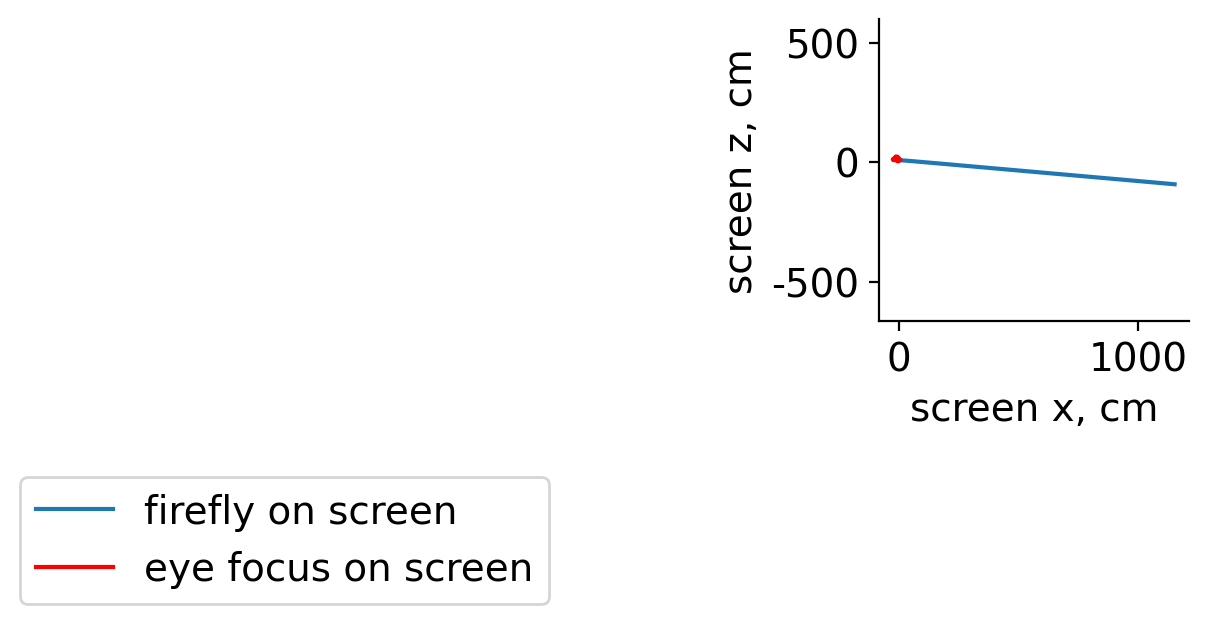

In [16]:
#  eye position on screen
with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    plt.plot(X['x_fly_screen'][trial_idx==trials[itrial]], X['z_fly_screen'][trial_idx==trials[itrial]], label='firefly on screen')
    plt.plot(X['x_eye_screen'][trial_idx==trials[itrial]], X['z_eye_screen'][trial_idx==trials[itrial]], label='eye focus on screen', color='red')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('screen x, cm')
    ax.set_ylabel('screen z, cm')
    quickleg(ax)
    # quicksave('example eye position on screen relative itrial{}'.format(itrial))


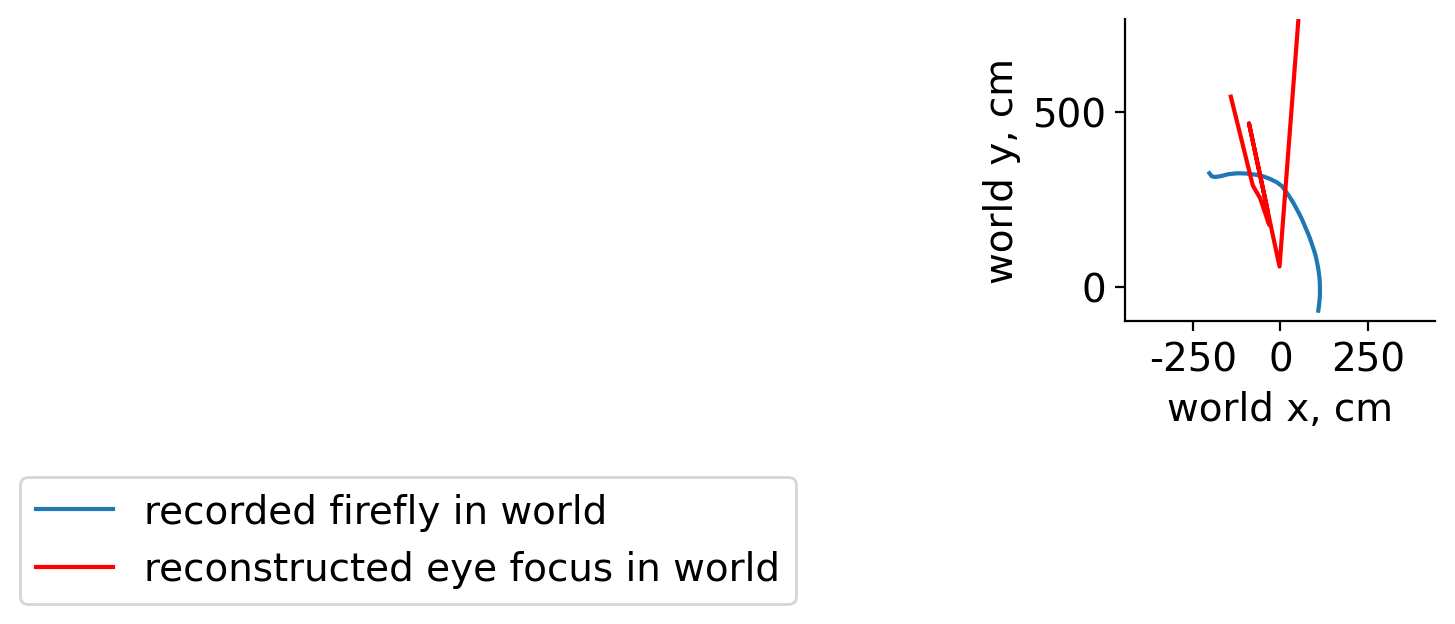

In [17]:
#  eye position in world
with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    plt.plot(X['x_fly_rel'][trial_idx==trials[itrial]], X['y_fly_rel'][trial_idx==trials[itrial]], label='recorded firefly in world')
    xx,yy=screen2world(X['x_eye_screen'][trial_idx==trials[itrial]], X['z_eye_screen'][trial_idx==trials[itrial]])
    plt.plot(xx, yy, label='reconstructed eye focus in world',color='red')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('world x, cm')
    ax.set_ylabel('world y, cm')
    plt.xlim(-444,444)
    plt.ylim(0,666)
    quickleg(ax)
    # quicksave('example eye position in world relative itrial{}'.format(itrial))


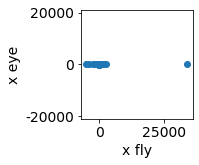

In [18]:
# check correlation to make sure sign is right
plt.scatter((X['x_fly_screen']), (X['x_eye_screen']))
plt.xlim(-2222,2222)
plt.xlabel('x fly')
plt.ylabel('x eye')
# plt.ylim(-100, 100)
plt.axis('equal')
plt.show()


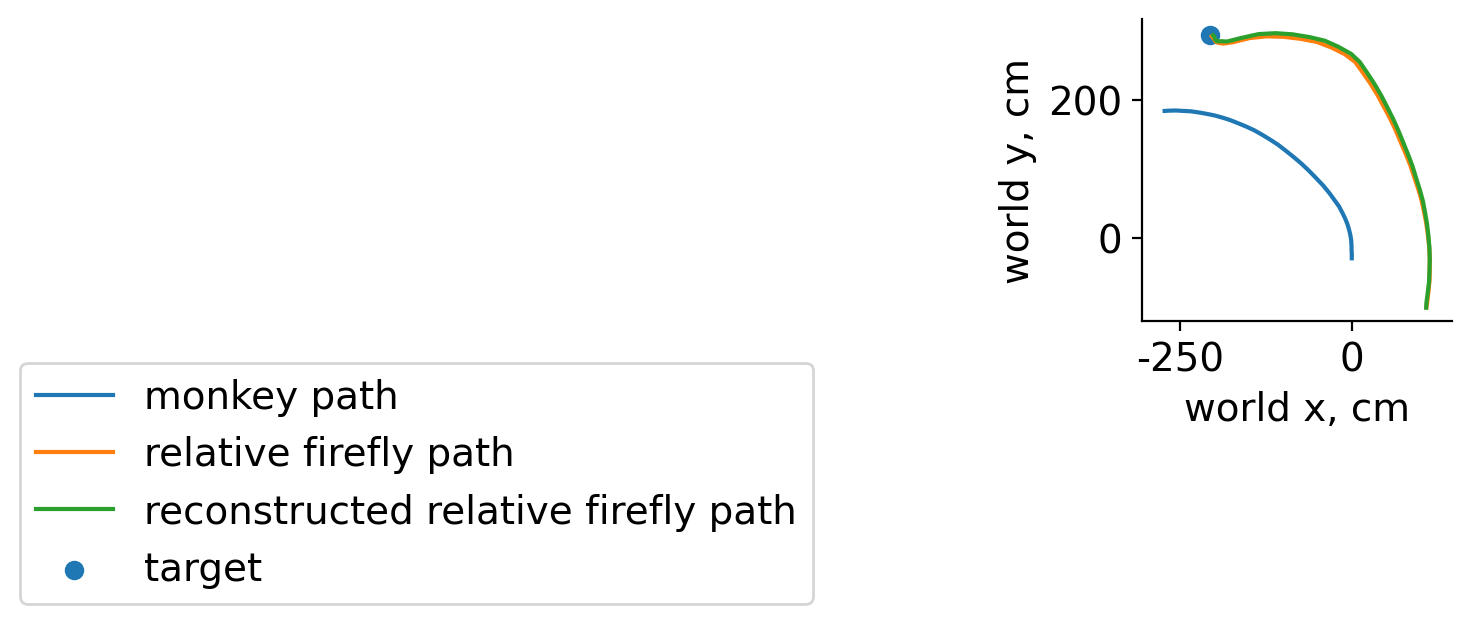

In [19]:
# reconstruct relative path
with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    plt.plot(X['x_monk'][trial_idx==trials[itrial]], X['y_monk'][trial_idx==trials[itrial]],label='monkey path')
    plt.plot(X['x_fly_rel'][trial_idx==trials[itrial]], X['y_fly_rel'][trial_idx==trials[itrial]]-32.5,label='relative firefly path')
    
    xr, yr=world2mk(X['x_monk'][trial_idx==trials[itrial]],X['y_monk'][trial_idx==trials[itrial]],X['ang_vel'][trial_idx==trials[itrial]],exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    plt.plot(xr, yr-32.5,label='reconstructed relative firefly path')

    plt.scatter(exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]],label='target')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('world x, cm')
    ax.set_ylabel('world y, cm')
    quickleg(ax)
    # quicksave('example overhead mk position relative itrial{}'.format(itrial))




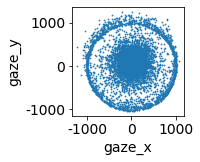

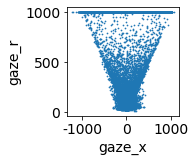

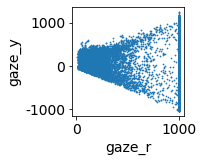

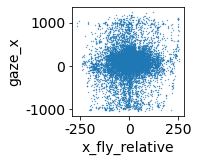

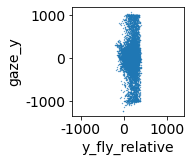

In [22]:
gaze_r,gaze_x,gaze_y=get_gaze_location(X['eye_vert'],X['eye_hori'],np.cumsum(X['ang_vel']),X['x_monk'],X['y_monk'])

def normalizematrix(data,low=5,high=95):
    themin=np.percentile(data[~np.isnan(data)],low)
    themax=np.percentile(data[~np.isnan(data)],high)
    res= (data - themin) / (themax- themin)
    res[np.isnan(data)]=np.nan
    res[data>themax]=np.nan
    res[data>themin]=np.nan
    return res


plt.scatter(gaze_x,gaze_y,s=0.5)
plt.xlabel('gaze_x');plt.ylabel('gaze_y')
plt.show()

plt.scatter(gaze_x,gaze_r,s=0.5)
plt.xlabel('gaze_x');plt.ylabel('gaze_r')
plt.show()

plt.scatter(gaze_r,gaze_y,s=0.5)
plt.xlabel('gaze_r');plt.ylabel('gaze_y')
plt.show()

plt.scatter(X['x_fly_rel'],gaze_y,s=0.1)
plt.xlabel('x_fly_relative');plt.ylabel('gaze_x')
plt.show()

plt.scatter(X['y_fly_rel'],gaze_x,s=0.1)
plt.xlabel('y_fly_relative');plt.ylabel('gaze_y')
plt.axis('equal')
plt.show()

plt.scatter(X['x_fly_rel'],X['y_fly_rel'],s=0.5)
plt.show()

plt.scatter(gaze_x,X['x_fly_rel'],s=0.5)
plt.scatter(gaze_y,X['y_fly_rel'],s=0.5)
plt.show()